<a href="https://colab.research.google.com/github/damido31/colabcopys/blob/main/MLP_for_density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import xarray as xr
import tensorflow as tf
from matplotlib import pyplot as plt
from IPython import display
layers = tf.keras.layers
ds = xr.open_dataset(
   "/content/drive/MyDrive/Data/canti_fpos0_10000.nc")

In [ ]:
index = [5]
density = ds.dens.sel(number=index).values.squeeze()
ux = ds.uxs.sel(number=index).values.squeeze()
uy = ds.uys.sel(number=index).values.squeeze()
sens = ds.sens.sel(number=index).values.squeeze()
figure = plt.figure(figsize=(10,10))
figure.add_subplot(2,2,1)
plt.imshow(density, cmap='Greys')
plt.title('density')
figure.add_subplot(2,2,2)
plt.imshow(ux)
plt.title('ux')
plt.colorbar()
figure.add_subplot(2,2,3)
plt.imshow(uy)
plt.title('uy')
plt.colorbar()
figure.add_subplot(2,2,4)
plt.imshow(sens)
plt.title('sens')
plt.colorbar()

In [ ]:
data = ds.uxs
means = data.mean(dim=['nnpy','nnpx']).values

# print(np.where(means>1)[0].shape)
# plt.imshow(means.reshape((-1,40)), cmap='rainbow')
# plt.colorbar()
# print(data.mean())
# print(data.std())
# print(data.max())
# print(data.min())

In [ ]:
bad_sample_indices = np.where(data.mean(dim=['nnpy','nnpx']).values > 1)[0]
ds = ds.drop_isel(number=bad_sample_indices)
ds

<xarray.Dataset>
Dimensions:  (number: 4798, nely: 20, nelx: 60, nnpy: 21, nnpx: 61, dofs: 2562)
Coordinates:
  * number   (number) int64 0 2 6 7 8 11 14 ... 9982 9983 9993 9996 9998 9999
Dimensions without coordinates: nely, nelx, nnpy, nnpx, dofs
Data variables:
    dens     (number, nely, nelx) float64 ...
    uxs      (number, nnpy, nnpx) float64 0.0 -35.23 -35.16 ... 435.5 437.3
    uys      (number, nnpy, nnpx) float64 ...
    disps    (number, dofs) float64 ...
    sens     (number, nely, nelx) float64 ...

In [ ]:
nelx, nely = ds.dens['nelx'].shape[0], ds.dens['nely'].shape[0]
nnpx, nnpy = nelx + 1, nely + 1
num_of_samples = ds.dens['number'].shape[0]
dens = ds.dens.values.reshape(num_of_samples, nelx * nely)
uxs = ds.uxs.values.reshape(num_of_samples, nnpx * nnpy)
uys = ds.uys.values.reshape(num_of_samples, nnpx * nnpy)
u = np.hstack((uxs,uys))

In [ ]:
from sklearn.model_selection import train_test_split
input_data, output_data = dens, u
input_train, input_valid, output_train, output_valid = train_test_split(
    input_data[:4000], output_data[:4000], test_size=0.2, random_state=123)

# normalization_layer = layers.Normalization()
# normalization_layer.adapt(input_data)

In [ ]:
input_neurons = nelx * nely
output_neurons = nnpx * nnpy * 2
def MLP(input_size=(input_neurons,)):
    
    # Input size represent the size of 1 image (the size used for pre-processing) 
    inputs = layers.Input(input_size)
    # inputs = normalization_layer(inputs)
    # dense = layers.Dense(input_neurons, activation='relu')(inputs)
    # dense = layers.Dense(input_neurons, activation='relu')(dense)
    outputs = layers.Dense(output_neurons)(inputs)
    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
mlp = MLP()
mlp.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.5), 
             loss=tf.keras.losses.MeanAbsoluteError(),
              metrics=['mean_squared_error'])
# mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
#              loss=tf.keras.losses.MeanAbsoluteError(),
#               metrics=['mean_squared_error'])
# filepath = '/content/drive/MyDrive/Model/cnn_4x_mae.hdf5'
# from keras.callbacks import ModelCheckpoint
# checkpoint = ModelCheckpoint(filepath=filepath, 
#                              monitor='val_loss',
#                              verbose=0, 
#                              save_best_only=True,
#                              mode='min')
# callbacks = [checkpoint]

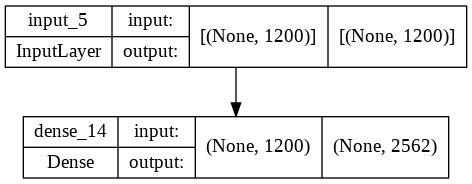

In [ ]:
from tensorflow import keras
keras.utils.plot_model(mlp, show_shapes=True)

In [ ]:
results = mlp.fit(input_train, output_train, batch_size=32, 
                        epochs=500, validation_data=(input_valid, output_valid))

In [ ]:
mlp.save('/content/drive/MyDrive/Model/mlp_mean1.h5')

In [ ]:
from tensorflow.keras.models import load_model
fe_sr_net = load_model('content/drive/MyDrive/Model/my_best_model.hdf5')
fe_sr_net.save('/content/drive/MyDrive/Model/cnn_4x_mse.h5')

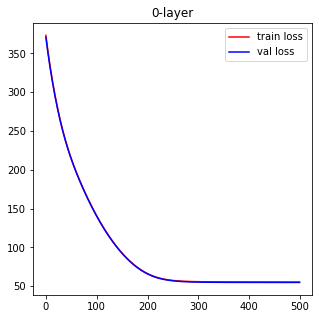

In [ ]:
import matplotlib.pyplot as plt
fig, axis = plt.subplots(1, 1, figsize=(5, 5))
axis.plot(results.history["loss"], color='r', label = 'train loss')
axis.plot(results.history["val_loss"], color='b', label = 'val loss')
axis.set_title('0-layer')
axis.legend()

In [ ]:
number=10
output_predicted = mlp.predict(input_valid[:number])
predicted_rescaled = output_predicted.reshape(number,2,nnpy,nnpx)
truth_rescaled = output_valid[:number].reshape(number,2,nnpy,nnpx)
predict_truth = np.stack((predicted_rescaled, truth_rescaled))

In [ ]:
ds_dual = xr.Dataset({
    'truth': (('number', 'uxy', 'nnpy', 'nnpx'), truth_rescaled),
    'predicted': (('number', 'uxy', 'nnpy', 'nnpx'), predicted_rescaled),
    }, coords={'number': np.arange(len(truth_rescaled))})
ds_temp = xr.Dataset({
    'compare': (('predict_or_truth','number', 'uxy', 'nnpy', 'nnpx'), predict_truth)
    }, coords={'number': np.arange(predict_truth.shape[1])})
ds_diff = xr.Dataset({
    'accuracy': (('number', 'uxy', 'nnpy', 'nnpx'), (truth_rescaled - predicted_rescaled) / truth_rescaled)
    }, coords={'number': np.arange(truth_rescaled.shape[0])})


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':


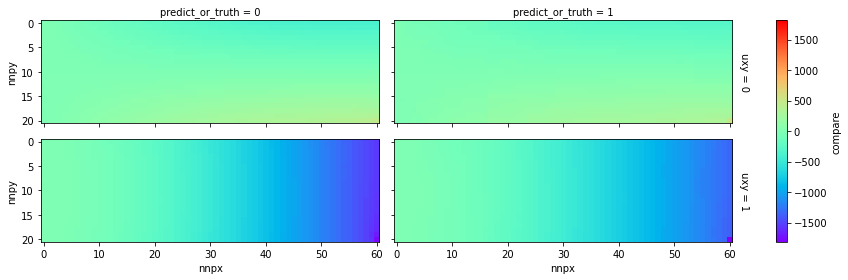

In [ ]:
# index = [i for i in range(50) if i > 0]
index = [8]
ds_sel = ds_temp.compare.sel(number=index).squeeze()
ds_sel.plot.imshow(
        col='predict_or_truth',row='uxy', x='nnpx', y='nnpy', size=2,aspect=3, 
        yincrease=False, add_colorbar=True, cmap='rainbow')

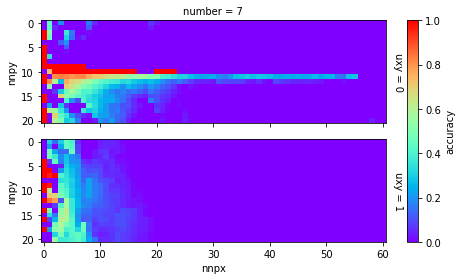

In [ ]:
# index = [i for i in range(50) if i > 0]
index=[7]
ds_diff.accuracy.sel(number=index).clip(0,1).plot.imshow(
        col='number', row='uxy', x='nnpx', y='nnpy', size=2, aspect=3,
        yincrease=False, add_colorbar=True, cmap='rainbow')

# for i in range(50):
#     ds_dual.predicted.sel(number=[i]).plot.imshow(
#         col='number', x='nelx', y='nely', size=2, 
#         yincrease=False, add_colorbar=True, cmap='rainbow')
#     ds_dual.truth.sel(number=[i]).plot.imshow(
#         col='number', x='nelx', y='nely', size=2, 
#         yincrease=False, add_colorbar=True, cmap='rainbow')

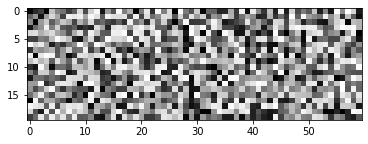

In [ ]:
plt.imshow(input_valid[2].reshape(nely,nelx), cmap='Greys')